<a href="https://colab.research.google.com/github/callor/Callor-DeepLearning-2022/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 삼성전자 주가 예측 

* 데이터출처 : https://finance.yahoo.com/quote/005930.KS/history?period1=1641009600&period2=1671076799&interval=1d&frequency=1d&filter=history

* 주가를 인공지능으로 예측한다는 것은 현실적으로 불가능에 가깝다라는 어느 경제 학자의 오래된 이야기가 생각난다. 
* 하지만, 데이터를 이용한 딥러닝 학습에 이만한 예제가 있을까 생각된다.
* 삼성전자의 2012년 1월 부터 2012년 12월 14일까지의 데이터를 `야후 파이넨셜` 에서 다운로드 받아 `LSTM` 알고리즘을 통한 주가 예측 딥러닝 모델링을 작성한다
* `파이토치(Pytorch)`를 사용한 LSTM 관련 문서를 참조하여 작성하였다.  
참조한 원본 프로젝트 출처 : https://cnvrg.io/pytorch-lstm/?gclid=Cj0KCQiA6t6ABhDMARIsAONIYyxsIXn6G6EcMLhGnPDxnsKiv3zLU49TRMxsyTPXZmOV3E-Hh4xeI2EaAugLEALw_wcB

In [ ]:
# 코랩 matplotlib 에서 한글을 사용하기 위한 폰트 설치치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# yahoo financel 에서 삼성 전자 불러오기 
start = (2012, 1, 1)  # 2012년 01년 01월 ~
start = datetime.datetime(*start)  
end = datetime.date.today()  # 현재 

# df = pdr.DataReader('005930.KS', 'yahoo', start, end)
# 야후에서 자동 다운로드가 되지 않는다
# Console 링크를 따라가서 csv 파일을 다운로드 받는다다
# https://finance.yahoo.com/quote/005930.KS/history?period1=1641009600&period2=1671076799&interval=1d&frequency=1d&filter=history

# 2012년 1월 4일 부터 2022년 12월 14일까지 일일 데이터를 다운로드 받아 파일로 생성.
# github 에 업로드된 데이터를 다운로드 받아 코랩 파일 디렉토리에 추가한 후 실행
# 데이터 URL : https://github.com/callor/Callor-DeepLearning-2022/blob/master/005930(2012-01-01).KS.csv
# 날짜 칼럼을 index 로 하여 데이터 만들기
df = pd.read_csv('005930(2012-01-01).KS.csv', index_col = 'Date', parse_dates=True)

# 불러온 데이터에 유효하지 않은 값이 있는지 확인
# 각 column 의 count 값을 확인하여 count 값이 다른 칼럼보다
# 작으면 해당 칼럼에 NaN 데이터가 존재한다는 것을 알 수 있다.

# 테이블에서는 count 뿐만 아니라, 
# mean / std와 같은 속성들에 대한 종합적인 정보도 제공해 준다
print(df.describe())

# .info()의 메소드를 활용해서도 NaN값이 어느 column에서 빠졌는지 쉽게 확인할 수 있다.
print(df.info())


               Open          High           Low         Close     Adj Close  \
count   2695.000000   2695.000000   2695.000000   2695.000000   2695.000000   
mean   43057.395176  43461.243043  42644.478664  43045.703154  38652.386014   
std    17902.852552  18046.177797  17752.803949  17880.147465  18804.722204   
min    20320.000000  20480.000000  20220.000000  20320.000000  16251.537110   
25%    26770.000000  26960.000000  26490.000000  26740.000000  21786.947270   
50%    41950.000000  42440.000000  41700.000000  42140.000000  37181.941410   
75%    54400.000000  54850.000000  53800.000000  54250.000000  49188.619140   
max    90300.000000  96800.000000  89500.000000  91000.000000  87764.796880   

             Volume  
count  2.695000e+03  
mean   1.410899e+07  
std    7.224147e+06  
min    0.000000e+00  
25%    9.591050e+06  
50%    1.244584e+07  
75%    1.649126e+07  
max    9.030618e+07  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2695 entries, 2012-01-02 to 2022-12-1

In [ ]:
# 처음부터 5개의 데이터 보여주기
# df.head(5)

# 끝에서 10개의 데이터 보여주기
# 최근 날짜로 부터 10일 전까지 보여주기기
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-01,63100,63200,62300,62600,62600.0,16631445
2022-12-02,62500,62500,60400,60400,60400.0,15331184
2022-12-05,60900,61100,60000,60300,60300.0,13767787
2022-12-06,59800,60100,59200,59200,59200.0,13888300
2022-12-07,58800,59600,58500,58900,58900.0,12100662
2022-12-08,58700,59200,58600,59200,59200.0,12986815
2022-12-09,59300,60600,59300,60400,60400.0,10529632
2022-12-12,59900,60000,59400,59500,59500.0,9036472
2022-12-13,59600,60300,59400,59700,59700.0,9040873


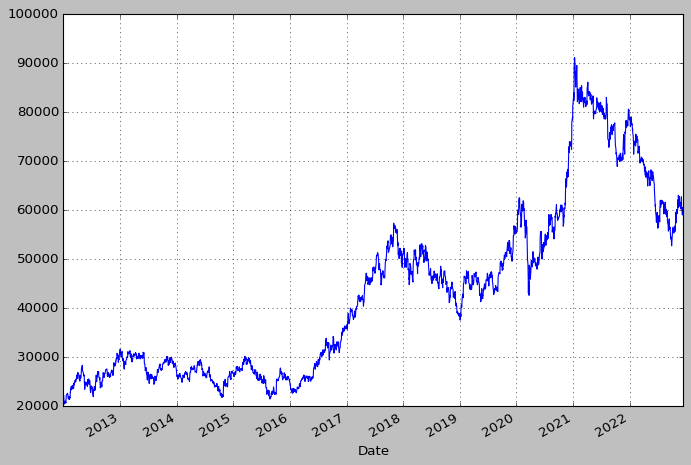

In [ ]:
# 종가 기준으로 그래프 그리기
# 프로젝트에서 제시한 방법으로 그려보기
plt.style.use('classic')

df.Close.plot(grid=True)

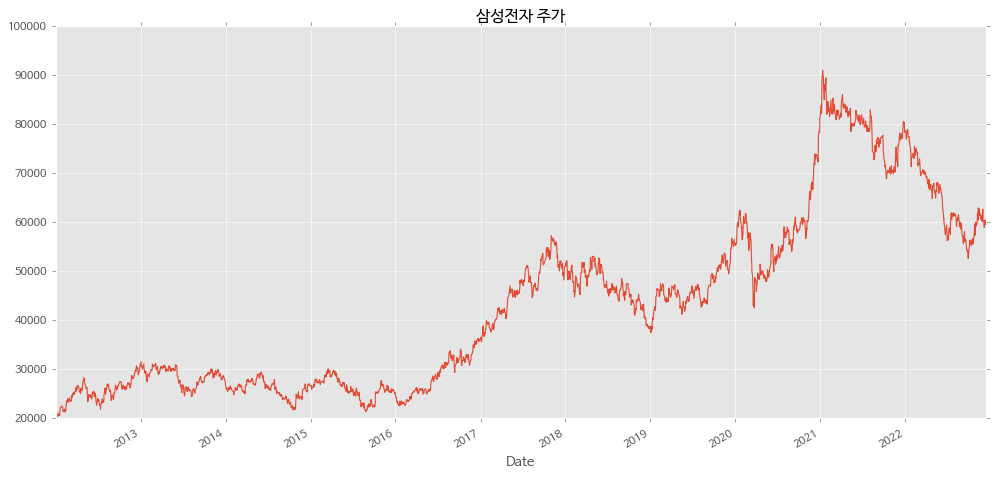

In [ ]:
# matplotlib 에서 한글을 사용하기 위해 폰트 세팅
plt.rc('font', family='NanumBarunGothic') 

# plot ggplot 스타일 지정하여 그래프 그리기
plt.style.use('ggplot')
plt.figure(figsize=(15,7)) 

# 종가 기준으로 그래프 그리기
# 한글 문제를 해결하기 위해 처음부분에서 폰트 다운로드 받고 세팅을 해주어야 함
# 테스트 하는 과정에서 폰트 설정이 변경면 다시 세팅부분을 실행해 주어야 함함
df['Close'].plot(title='삼성전자 주가')

## 데이터 정규화와 표준화
### 학습이 좀더 잘 될수 있도록 샘플데이터를 표준화와 정규화를 실시하기 위한 데이터 추출
### 표준화된 데이터와 정규화된 라벨을 만들어 낸다

### 표준화(StandardScaler 함수사용)
* 모든 데이터들을 평균이 0이고 분산이 1인 정규 분포로 만드는 것이다.  
수학식부터 살펴보면 굉장히 간단하다.  
(Xi - (X의 평균)) / (X의 표준편차)

* 예시로 설명을 하자면, 만약 평균이 50이인데 임의 숫자는 49라 하자,  
(49-50) / 1 = -1이다.  
여기서 표준편차란 평균으로부터 얼마나  떨어져있는지를 구한 것이다. 
* 다음의 라이브러리를 사용한다.
```
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris
import pandas as pd
```

### 정규화(MinMaxScaler 함수사용)
* 정규화란, 모든 값을 0~1 사이의 값으로 바꾸는 것이다. 음수도 예외 없이 다 바꾼다. 표준화와는 차이가 있다.
* 수학식을 보면,  
( X- (X의 최솟값) ) / ( X의 최댓값 - X의 최솟값 )이다. 
* 예를들어 최댓값 10, 최솟값 2 일 때, 4는 어떻게 정규화될까?  
(4 - 2) / (10 - 2 ) = 0.25로 정규화될 수 있다.

* 다음의 라이브러리를 사용한다
```
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_iris
import pandas as pd
```

In [ ]:
# 파일에 있는 데이터의 각 항목은 다음과 같다
##  open 시가
##  high 고가
##  low 저가
##  close 종가
##  volume 거래량
##  Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

# 필요데이터 추출하기 방법 1
# 여기에서 거래량(Volume)은 데이터에서 삭제를 하고,
#   X(데이터) 값으로는 Volume 이 제거된 데이터를 담고
#   y(라벨) 값으로 Close(종가)를 담는다.
X = df.drop(columns='Volume')
#   y = df.iloc[:, 5:6]

# 필요데이터 추출하기 방법 2
#   X(데이터) 값으로는 Volume 이 제거된 데이터를 담고
# X = df.iloc[:, :-2]

# y(라벨) 값으로 Close(종가)를 담는다.
# 날짜(index) 와 종가데이터만 추출
y = df.iloc[:, 4:5] 

print(X)
print(y)

             Open   High    Low  Close    Adj Close
Date                                               
2012-01-02  21400  21600  21300  21600  17275.26367
2012-01-03  21860  22100  21840  22100  17675.15430
2012-01-04  22100  22200  21500  21600  17275.26367
2012-01-05  21460  21580  21100  21100  16875.36914
2012-01-06  21120  21320  20600  20800  16635.43359
...           ...    ...    ...    ...          ...
2022-12-08  58700  59200  58600  59200  59200.00000
2022-12-09  59300  60600  59300  60400  60400.00000
2022-12-12  59900  60000  59400  59500  59500.00000
2022-12-13  59600  60300  59400  59700  59700.00000
2022-12-14  59800  60600  59800  60300  60300.00000

[2695 rows x 5 columns]
              Adj Close
Date                   
2012-01-02  17275.26367
2012-01-03  17675.15430
2012-01-04  17275.26367
2012-01-05  16875.36914
2012-01-06  16635.43359
...                 ...
2022-12-08  59200.00000
2022-12-09  60400.00000
2022-12-12  59500.00000
2022-12-13  59700.00000
2022-12-14 

In [ ]:

# 학습이 잘 될 수 있도록 데이터를 표준화와 정규화를 수행한다
# StandardScaler : 각 특징의 평균을 0, 분산을 1이 되도록 변경한다
# MinMaxScaler : 최대/최소값이 각각 1, 0이 되도록 변경
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 표준화를 위한 함수
ss = StandardScaler()

# 정규화를 하기위한 함수
mm = MinMaxScaler()

# 이렇게 하면 데이터 세트가 변환되고 크기가 조정됩니다.
X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# 표준화된 데이터에서 학습데이터 추출

# 표준화된 데이터 세트를 두 부분으로 나눈다.
# 순차 데이터이고 순서가 중요하므로 처음 2500개 행을 학습용으로, 
# 나머지 행을 데이터 테스트용으로 사용한다. 
X_train = X_ss[:2400, :]
X_test = X_ss[2400:, :]

# 정규화된 데이터에서 학습데이터 추출
# 예측데이터와 실제 데이터의 정확도를 확인하기 위해 
# from sklearn.metrics import accuracy_score 를 통해 정확한 값으로 확인할 수 있다. )
y_train = y_mm[:2400, :]
y_test = y_mm[2400:, :] 

# 확인을 위해 교육 및 테스트 데이터 셰이프를 인쇄
# 표준화된 데이터는 index(Date) 제외 4개의 칼럼을 가지며, 
# 정규화된 데이터는 index(Date) 제외 1개의 칼럼을 갖는다.
print("Training Shape", X_train.shape , y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 
print(X_ss)
print(y_mm)


Training Shape (2400, 5) (2400, 1)
Testing Shape (295, 5) (295, 1)
[[-1.20994206 -1.21163054 -1.20253904 -1.19963681 -1.1370064 ]
 [-1.18424307 -1.1839187  -1.17211566 -1.17166764 -1.11573702]
 [-1.17083489 -1.17837633 -1.19127112 -1.19963681 -1.1370064 ]
 ...
 [ 0.94095231  0.91663877  0.94399909  0.92042588  1.10884291]
 [ 0.9241921   0.93326587  0.94399909  0.93161354  1.11948051]
 [ 0.93536557  0.94989298  0.96653493  0.96517654  1.15139331]]
[[0.0143152 ]
 [0.01990704]
 [0.0143152 ]
 ...
 [0.60476145]
 [0.60755814]
 [0.61594819]]


In [ ]:

# PyTorch에서 프로그래밍하는 경우 PyTorch에서 다루는 모든 것은 
# numpy의 강력한 버전으로 생각할 수 있는 텐서라는 것을 알아야 한다.
# 따라서 데이터 세트를 텐서로 변환해야 한다
# 이 간단한 코드를 통해 Numpy 배열을 Tensor 및 변수(구분 가능)로 간단히 변환한다
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

# 이제 LSTM의 입력 형식을 확인한다.
# 즉, LSTM은 순차 데이터용으로 특별히 제작되었기 때문에 
# 단순한 2차원 데이터를 입력으로 사용할 수 없다. 
# 입력데이터에 타임스템프가 필요하므로 타임 스탬프를 포함하는 
# 데이터세트로 변환한다
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 
print(X_train_tensors_final)

Training Shape torch.Size([2400, 1, 5]) torch.Size([2400, 1])
Testing Shape torch.Size([295, 1, 5]) torch.Size([295, 1])
tensor([[[-1.2099, -1.2116, -1.2025, -1.1996, -1.1370]],

        [[-1.1842, -1.1839, -1.1721, -1.1717, -1.1157]],

        [[-1.1708, -1.1784, -1.1913, -1.1996, -1.1370]],

        ...,

        [[ 1.7734,  1.7646,  1.7553,  1.7371,  1.7973]],

        [[ 1.7454,  1.7369,  1.7497,  1.7371,  1.7973]],

        [[ 1.7231,  1.6926,  1.7046,  1.6868,  1.7505]]])


In [ ]:
# tensor 로 완성된 학습 데이터 확인
print(X_train_tensors_final[:5])

tensor([[[-1.2099, -1.2116, -1.2025, -1.1996]],

        [[-1.1842, -1.1839, -1.1721, -1.1717]],

        [[-1.1708, -1.1784, -1.1913, -1.1996]],

        [[-1.2066, -1.2127, -1.2138, -1.2276]],

        [[-1.2256, -1.2271, -1.2420, -1.2444]]])


In [ ]:
# 학습을 실행할 디바이스의 CPU 를 정한다
# cuda GPU 나 CPU 를 선택한다
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# cuda GPU 가 있는경우 다음 주석 제거거
# print(torch.cuda.get_device_name(0))

### 이제 학습 할 준비 도구를 마련한다. 
* LSTM 모델을 만들 클래스를 정의한다. 
* PyTorch는 훨씬 더 파이썬적이기 때문에 PyTorch의 모든 모델은   
`nn.Module` 슈퍼클래스를 상속받는 사용자정의 클래스를 만든다


```
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length
```    
*  `hidden_size`를 통해 서로 겹쳐진 동일한 하이퍼파라미터가 있는 
2개의 LSTM 레이어를 사용하고,  
2개의 완전 연결 레이어, ReLU 레이어 및 일부 도우미 변수를 정의한다.
* 다음으로 LSTM의 순방향 패스를 정의한다.



In [ ]:

class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length
 
    # LSTM
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,num_layers=num_layers, batch_first=True) 
    
    # fully connected 1 생성
    # 이전 레이어의 모든 노드가 다음 레이어의 모든 노드에 연결된 레이어를 
    # Fully Connected Layer(FC Layer)라고 한다. 
    # FC Layer를 Dense Layer라고도 한다
    self.fc_1 =  nn.Linear(hidden_size, 128) 

    # fully connected last layer
    self.fc = nn.Linear(128, num_classes) 

    # ReLu() 함수 적용
    self.relu = nn.ReLU() 

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) # internal state   
    
    # Propagate input through LSTM

    #lstm with input, hidden, and internal state
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) 
   
    #reshaping the data for Dense layer next
    hn = hn.view(-1, self.hidden_size) 
    out = self.relu(hn) # 첫 ReLu 층 통과
    out = self.fc_1(out) # 첫번째 Dense 층 통과
    out = self.relu(out) # ReLu 함수 층 통과
    out = self.fc(out)   # 최종 출력 층 통과
  
    return out 

print(LSTM1)

<class '__main__.LSTM1'>


### 중요한 변수와 레이어를 정의한다.

```
  가. input_size: input의 feature dimension을 넣어준다. time step이 아니라 input feature dimension!
  나. hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어준다.
  다. num_layers: lstm layer를 얼마나 쌓을지
  라. bias: bias term을 둘 것인가 (Default: True)
  마. batch_first: batch가 0번 dimension으로 오게 하려면 설정  
      batch_first=False라면, (Time_step, Batch_size, Input_feature_dimension) 순서
    batch_first=True라면, (Batch_size, Time_step, Input_feature_dimension) 순서.
  바. dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정한다.
  사. bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)
```

* 숨겨진 상태와 내부 상태를 먼저 정의하고 0으로 초기화했다.  
현재 타임스탬프 t의 입력과 함께 숨겨진 상태와 내부 상태를 LSTM에 전달한다.  
그러면 새로운 숨겨진 상태, 현재 상태 및 출력이 반환된다 
* 출력이 Dense Layer로 전달될 수 있도록 모양을 변경한다. 
* 다음으로 간단히 활성화를 적용하고 고밀도 레이어에 전달한 다음 출력을 반환한다.   
* 런타임 시 모델을 교육하는 동안 backpropagation logic을 적용한다

### hidden state
*  RNN은 전 시점의 어떤 정보를 다음 시점으로 넘겨준다고 볼 수 있다.
* 다음 시점의 정보는 전 시점의 정보만이 아니라 이전까지의 정보들을 모두 가지고 있을 것이다
* 그리고 이처럼 정보를 가지고 있는 것을 cell이라고 하며 현재 cell이 가지고 있는 정보, 즉 다음 시점으로 넘겨줄 정보를 hidden state라고 한다.

### learning_rate(학습률)
* 학습률은 최소값으로 크게 진동하지 않고 최소값에 도달하거나 무한대로 분기하지 않고 손실 함수가 완만하게 내려갈 수 있을 정도로 작아야한다
* 또한, 최적화가 적당한 시간 내에 이루어 지도록 충분히 커야 한다
* 하나의 매개 변수에 대해 그라디언트 하강에 제공하는 것으로 학습 속도가 있다.
* 충분히 작거나 충분히 큰 학습률은 너무 모호하다  
적절한 학습 속도 선택을 다루는 현명한 방법은 소위 학습 속도 스케쥴을 채택하는 것이다  
학습 속도 스케쥴은 가장 좋은 방법 중 하나이다

In [ ]:
num_epochs = 1000 # 1000 epochs

# 학습 속도 설정
# 학습 속도를 변화시켜 가면서 학습결과를 분석하여 가장 근접한 값을 찾았다다
learning_rate = 0.001 # 0.001 lr

# 특성(features) 개수
input_size = 5

# 특성의 hidden state 개수
hidden_size = 5

# LSTM 레이어 개수
num_layers = 1

# 출력 객체수
num_classes = 1

In [ ]:
# 위에서 선언한 LSTM 클래스를  사용하여 LSTM 모델 생성
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) 

# 회귀에 대한 평균 제곱 오차 계산
# 입력의 각 요소 사이의 평균 제곱 오차 (제곱 L2 표준)를 측정하는 기준을 생성
criterion = torch.nn.MSELoss()    

# 옵티마이저 적용
# 최소의 손실값을 찾기 위해 손실함수의 미분으로 구한 기울기를 따라 이동하게 되는데, 
# 이동하는 방식에 대한 선택에 대한 것이다 SGD 방식, Adam 방식 등이 있는데
# 여기에서는 Adam을 적용하였다.
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

# Adam 옵티마이져의 결과를 출력 확인한다
print(optimizer)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [ ]:
# 학습하기
# 1000 epoch 를 실행하고
# 100 epoch 마다 손실을 출력한다다
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final)

  # 기울기를 계산하고 수동으로 0으로 설정
  optimizer.zero_grad()
 
  # 손실함수 얻기
  loss = criterion(outputs, y_train_tensors)
   
  # 손실함수를 통해 손실값을 계산
  loss.backward()
 
  # backpropagation 을 통해 손실로 부터 개선점 찾기
  optimizer.step()

  # 100 epoch 마다 결과를 보여주기
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.25812
Epoch: 100, loss: 0.02665
Epoch: 200, loss: 0.01195
Epoch: 300, loss: 0.00160
Epoch: 400, loss: 0.00065
Epoch: 500, loss: 0.00047
Epoch: 600, loss: 0.00022
Epoch: 700, loss: 0.00011
Epoch: 800, loss: 0.00006
Epoch: 900, loss: 0.00004


In [ ]:
# 손실이 적고 성능이 좋다는 것을 알 수 있다.
# 데이터 세트에 대한 예측을 플로팅하여 성능을 확인하겠습니다.


# 전체 데이터 세트에 대한 예측을 수행하기 전에 
# 원본 데이터 세트를 모델에 적합한 형식으로 가져온다
df_X_ss = ss.transform(df.iloc[:, :-1]) 
df_y_mm = mm.transform(df.iloc[:, -2:-1])

# converting to Tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 




이제 순방향 패스를 통해 전체 데이터 세트에 대한 예측을 수행한 다음 플롯하기 위해 예측을 numpy로 변환하고 역변환 한다

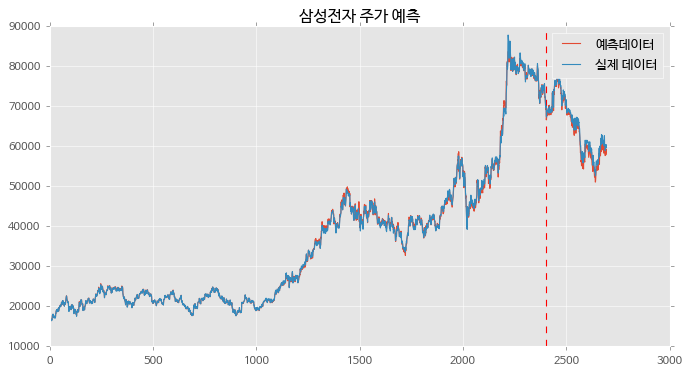

In [ ]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
data_predict = mm.inverse_transform(data_predict) #reverse transformation

dataY_plot = df_y_mm.data.numpy()
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(10,5)) #plotting
plt.axvline(x=2400, c='r', linestyle='--') #size of the training set

plt.plot(data_predict, label='예측데이터') #predicted plot
plt.plot(dataY_plot, label='실제 데이터') #actual plot

plt.title('삼성전자 주가 예측')
plt.legend()
plt.show() 
# 더 작은 데이터 세트를 사용함에도 불구하고 모델이 꽤 잘 수행되고 있음을 알 수 있습니다